In [1]:
try:
    import tools.invariants.functions as f
    from tools.invariants.invariant import Invariant
    from tools.invariants.bancor import BancorInvariant, BancorSwapFunction
    from tools.invariants.solidly import SolidlyInvariant, SolidlySwapFunction
    from testing import *
except:
    import fastlane_bot.tools.invariants.functions as f
    from fastlane_bot.tools.invariants.invariant import Invariant
    from fastlane_bot.tools.invariants.bancor import BancorInvariant, BancorSwapFunction
    from fastlane_bot.tools.invariants.solidly import SolidlyInvariant, SolidlySwapFunction
    from fastlane_bot.testing import *
    
import numpy as np
import math as m
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12,6]

print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(f.Function))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(BancorInvariant))

imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require, Timer
Function v0.9.1 (7/Feb/2024)
BancorInvariant v0.9 (18/Jan/2024)


# Invariants Module

## General invariants

In [2]:
inv = BancorInvariant()

### goal seek

testing on $(x-1)(x+1)$

In [3]:
func = lambda x: x**2 - 1
assert iseq(inv.goalseek_gradient(func, x0=-0.1), -1)
assert iseq(inv.goalseek_gradient(func, x0=0.1), 1)

In [4]:
assert iseq(inv.goalseek_bisect(func, x_lo=0, x_hi=10), 1)
assert iseq(inv.goalseek_bisect(func, x_lo=0, x_hi=-10), -1)

testing on AMM invariant $k/x$

In [5]:
assert iseq(inv.goalseek_gradient(lambda x: 100/x - 5), 20)
assert iseq(inv.goalseek_gradient(lambda x: 100/x - 20), 5)
assert iseq(inv.goalseek_gradient(lambda x: 100/x - 10), 10)
assert iseq(inv.goalseek_gradient(lambda x: 100/x - 50), 2)

#### timing 

In [6]:
inv.y_func(20, k=100), inv.y_func_from_k_func(20, k=100), inv.y_func_from_k_func(20, k=100, method=inv.GS_BISECT)

(5.0, 4.9999999999999725, 4.999999997468219)

note that the gradient method is almost certainly going to be faster than bisection, unless we are very good at bracketing (or put the tolerance very low)

In [7]:
r = (
    timer(inv.y_func, x=20, k=100, N=1000), 
    timer(inv.y_func_from_k_func, x=20, k=100, method=inv.GS_GRADIENT, N=10_000),
    timer(inv.y_func_from_k_func, x=20, k=100, method=inv.GS_BISECT, N=10_000),
    timer(inv.y_func_from_k_func, x=20, k=100, x_lo=0.1, x_hi=10, method=inv.GS_BISECT, N=10_000),
)
r, (1, r[1]/r[0], r[2]/r[0])

((459.1941833496094, 1466.512680053711, 9969.925880432129, 5298.399925231934),
 (1, 3.1936656282450673, 21.71178608515057))

### Bancor invariant function

we are here comparing the analytic invariant function with the one obtained numerically; note: they are a good match!

In [8]:
f = BancorSwapFunction(k=100)
assert f(10) == 10
assert f(5) == 20
assert f(20) == 5
inv = BancorInvariant()
assert inv.y_func_is_analytic is True

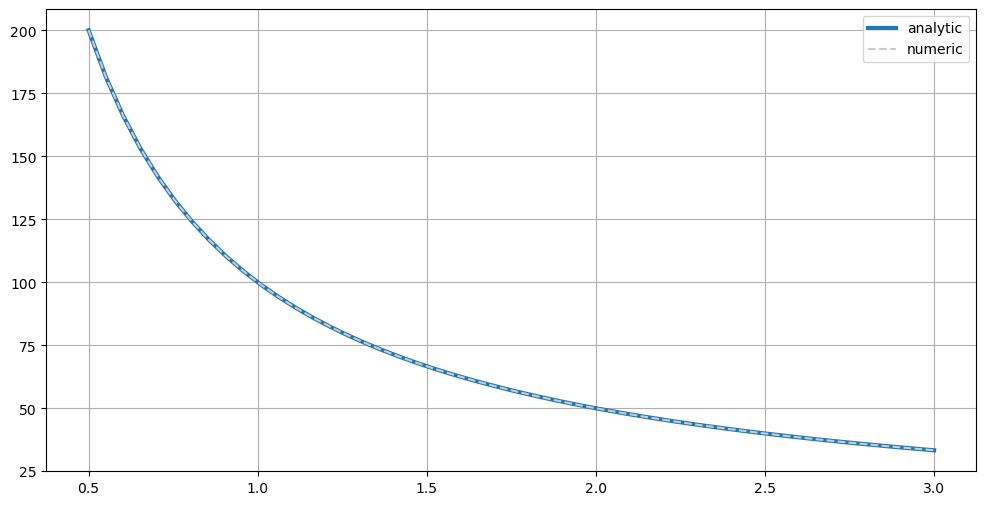

In [9]:
x_v = np.linspace(0.5 , 3, 50)
y1_v = [inv.y_func(xx, k=100) for xx in x_v]
y2_v = [inv.y_func_from_k_func(xx, k=100) for xx in x_v]
plt.plot(x_v, y1_v, linewidth=3, label="analytic")
plt.plot(x_v, y2_v, linestyle="--", color = "#ccc", label="numeric")
plt.legend()
plt.grid()

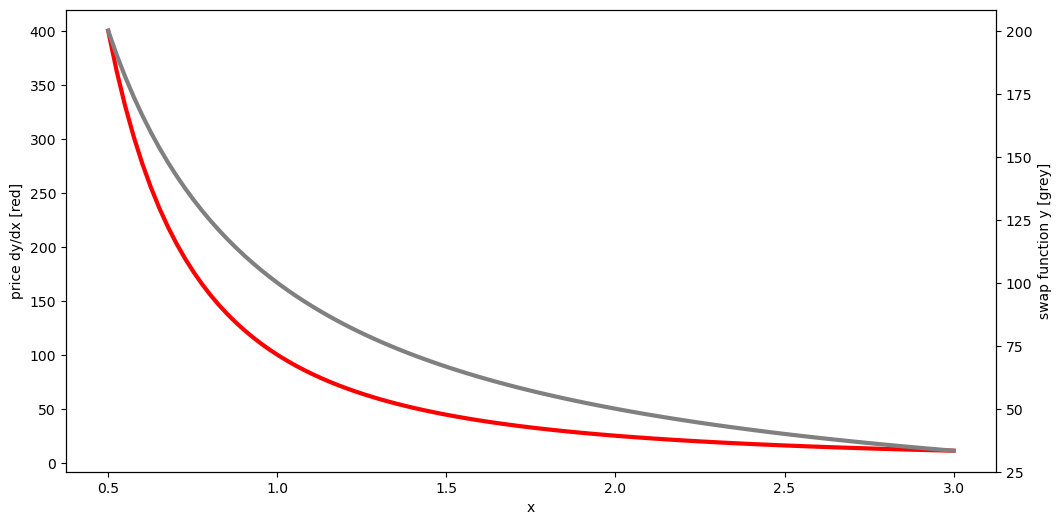

In [10]:
x_v = np.linspace(0.5, 3, 100)
y1_v = [inv.p_func(xx, k=100) for xx in x_v]
y2_v = [inv.y_func(xx, k=100) for xx in x_v]
plt.plot(x_v, y1_v, linewidth=3, color="red", label="p [LHS]")
plt.xlabel("x")
plt.ylabel("price dy/dx [red]")
ax2 = plt.twinx()
ax2.plot(x_v, y2_v, linewidth=3, color="grey", label="y [RHS]")
ax2.set_ylabel("swap function y [grey]")
#plt.grid()
plt.show()

#### timing

however, whilst the results are comparable, runtime difference is substantial (unsurprisingly especially given the extremely simple formula for the analytic function); for 1e-6 tolerance the factor is 27x, and for 1e-3 tolerance the factor is not much better at 19x

In [11]:
r = timer2(inv.y_func, 20, 100, N=1000), timer2(inv.y_func_from_k_func, 20, 100, N=1000)
r, r[1]/r[0]

((310.65940856933594, 1236.9155883789062), 3.9815809669992324)

### Solidly invariant function

The Solidly **invariant equation** is 
$$
    x^3y+xy^3 = k
$$

which is a stable swap curve, but more convex than for example Curve. 

To obtain the **swap equation** we solve the above invariance equation 
as $y=y(x; k)$. This gives the following result
$$
y(x;k) = \frac{x^2}{\left(-\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}\right)^{\frac{1}{3}}} - \frac{\left(-\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}\right)^{\frac{1}{3}}}{3}
$$

We can introduce intermediary **variables L and M** ($L(x;k), M(x;k)$) 
to write this a bit more simply

$$
L(x,k) = L_1(x) \equiv -\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}
$$
$$
M(x,k) = L^{1/3}(x,k) = \sqrt[3]{L(x,k)}
$$
$$
y = \frac{x^2}{\sqrt[3]{L}} - \frac{\sqrt[3]{L}}{3} = \frac{x^2}{M} - \frac{M}{3} 
$$

If we rewrite the equation for L as below we see that it is not 
particularly well conditioned for small $x$
$$
L(x,k) = L_2(x) \equiv \frac{27k}{2x} \left(\sqrt{1 + \frac{108x^8}{729k^2}} - 1 \right)
$$

For simplicity we introduce the **variable xi** $\xi=\xi(x,k)$ as
$$
\xi(x, k)  = \frac{108x^8}{729k^2}
$$

then we can rewrite the above equation as 
$$
L_2(x;k) \equiv \frac{27k}{2x} \left(\sqrt{1 + \xi(x,k)} - 1 \right)
$$

Note the Taylor expansion for $\sqrt{1 + \xi} - 1$ is 
$$
\sqrt{1+\xi}-1 = \frac{\xi}{2} - \frac{\xi^2}{8} + \frac{\xi^3}{16} - \frac{5\xi^4}{128} + O(\xi^5)
$$

and tests suggest that it is very good for at least $|\xi| < 10^{-5}$

### L functions

In [12]:
f = SolidlySwapFunction(k=100)
assert f.method == f.METHOD_DEC1000
inv = SolidlyInvariant()

In [13]:
x,k = 1,1000
(
    f._L1_float(x, k),
    f._L1_dec100(x, k),
    f._L1_dec1000(x, k),
    f._L2_taylor(x, k),
    f.L(x, k),
    f.L(x, k) == f._L2_taylor(x, k),
    f.L(x, k) == f._L1_dec100(x, k),
    f.L(x, k) == f._L1_dec1000(x, k),
)

(0.0009999999638239387,
 0.0009999999629629658,
 0.0009999999629629658,
 0.0009999999629629656,
 0.0009999999629629658,
 False,
 True,
 True)

In [14]:
# x,k = 1,10
# assert iseq(f._L1_dec(x, k), f._L1_float(x, k), f._L2_taylor(x, k))
# x,k = 1,100
# assert iseq(f._L1_dec(x, k), f._L1_float(x, k), f._L2_taylor(x, k))
# x,k = 1,1_000
# assert iseq(f._L1_dec(x, k), f._L1_float(x, k), f._L2_taylor(x, k))
# x,k = 1,10_000
# assert iseq(f._L1_dec(x, k), f._L1_float(x, k), f._L2_taylor(x, k))
# x,k = 1,100_000
# assert iseq(f._L1_dec(x, k), f._L2_taylor(x, k)) # not float !
# f._L1_dec(x, k), f._L1_float(x, k), f._L2_taylor(x, k)

### Numeric vs analytic and verification

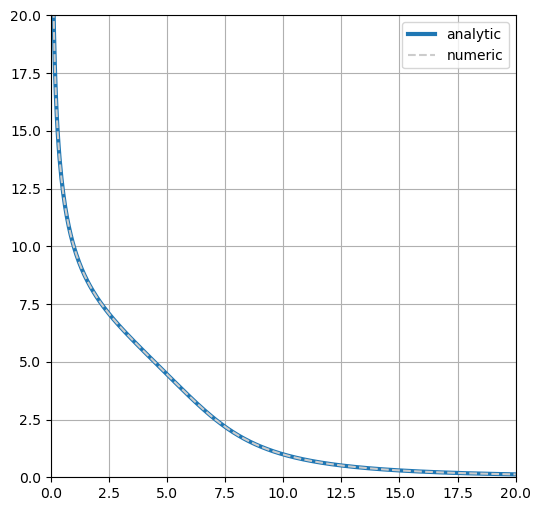

In [15]:
fig = plt.figure(figsize=(6, 6))
k = 1000
x_v = np.linspace(0.1 , 20, 500)
y1_v = [inv.y_func(xx, k=k) for xx in x_v]
y2_v = [inv.y_func_from_k_func(xx, k=k) for xx in x_v]
plt.plot(x_v, y1_v, linewidth=3, label="analytic")
plt.plot(x_v, y2_v, linestyle="--", color = "#ccc", label="numeric")
plt.xlim(0,20)
plt.ylim(0,20)
plt.legend()
plt.grid()

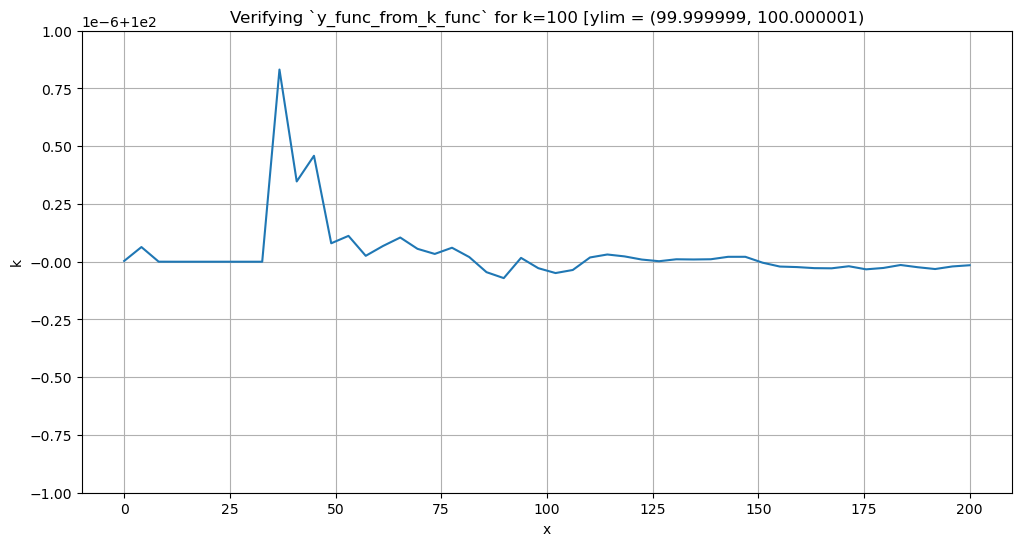

In [16]:
k = 100
x1_v = np.linspace(0, 200)
x1_v[0] = 0.0001
k_v = [inv.k_func(xx, inv.y_func_from_k_func(xx, k=100)) for xx in x1_v]
plt.plot(x1_v, k_v)
ylim = (99.999999, 100.000001)
assert min(k_v) > ylim[0]
assert max(k_v) < ylim[1]
plt.ylim(*ylim)
plt.title(f"Verifying `y_func_from_k_func` for k=100 [ylim = {ylim}")
plt.xlabel("x")
plt.ylabel("k")
plt.grid()

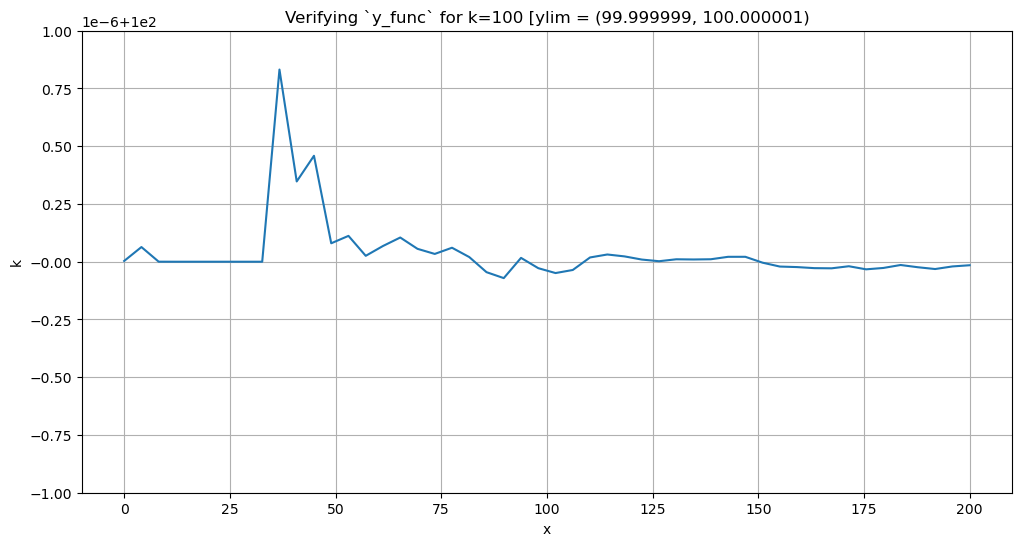

In [17]:
k = 100
x1_v = np.linspace(0, 200)
x1_v[0] = 0.0001
k_v = [inv.k_func(xx, inv.y_func(xx, k=100)) for xx in x1_v]
plt.plot(x1_v, k_v)
ylim = (99.999999, 100.000001)
assert min(k_v) > ylim[0]
assert max(k_v) < ylim[1]
plt.ylim(*ylim)
plt.title(f"Verifying `y_func` for k=100 [ylim = {ylim}")
plt.xlabel("x")
plt.ylabel("k")
plt.grid()

### Curves at different k

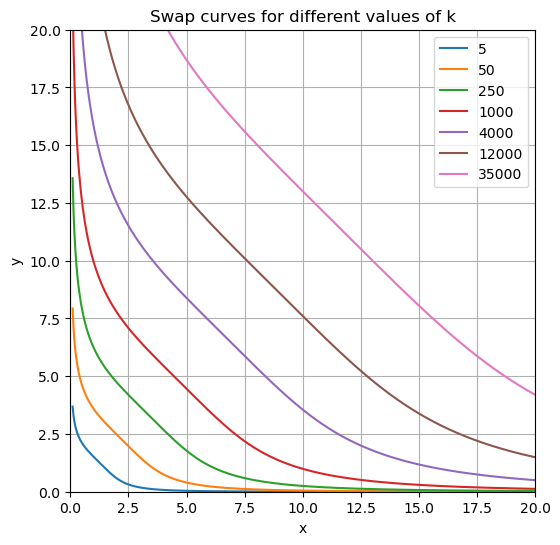

In [18]:
fig = plt.figure(figsize=(6, 6))
k_v = [5, 50, 250, 1000, 4000, 12000, 35000]
x_v = np.linspace(0.1 , 20, 500)
y_v_by_k = {kk: [inv.y_func(xx, k=kk) for xx in x_v] for kk in k_v}
for kk, y_v in y_v_by_k.items():
    plt.plot(x_v, y_v, label=f"{kk}")
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Swap curves for different values of k")
plt.legend()
plt.grid()